# Model embeddings and similarity assignment


**What this notebook does:**
1. Loads a .csv containing species name and their backgrounds
2. Loads a subgraph with nodes meant to be specific to the model.
3. Generates embeddings on each side using a pre-trained BERT model
4. We compare embeddings from the species name/background to the node's enriched feature in the KG
5. We keep the best node in the graph and extract the code within the KG.

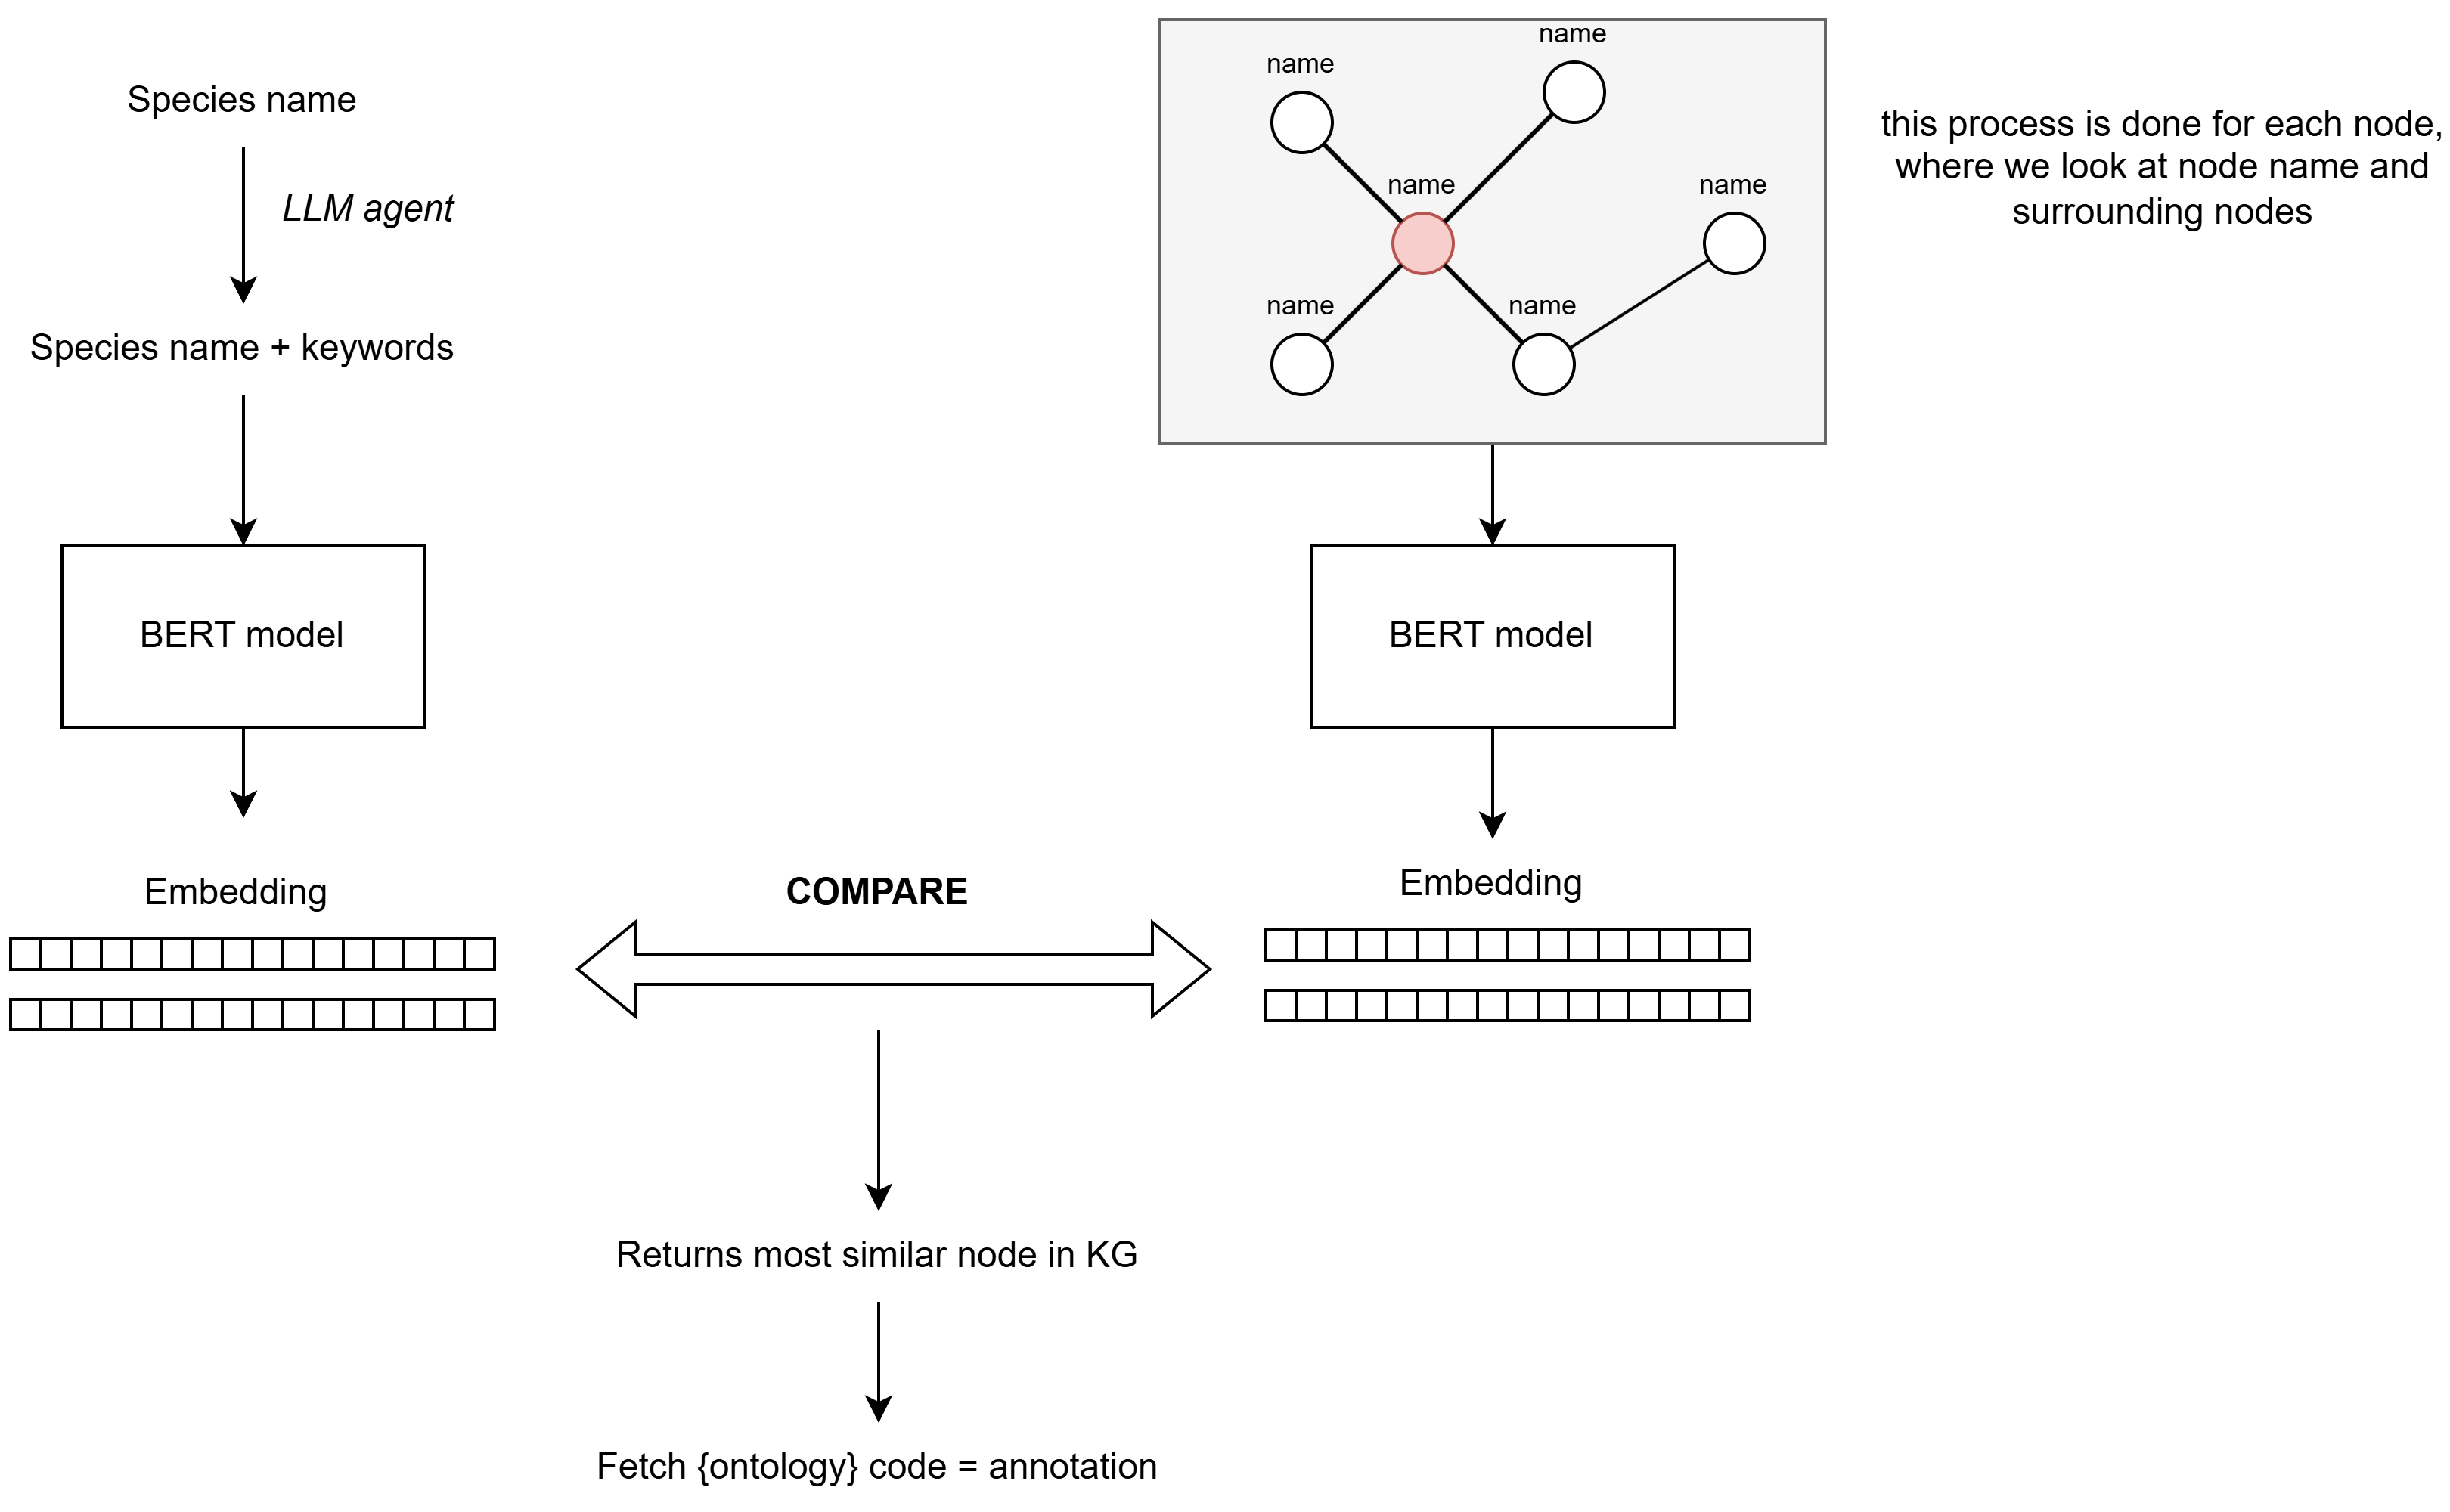

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import networkx as nx
import pickle
from tqdm import tqdm
from torch_geometric.utils import from_networkx
import sys

import matplotlib.pyplot as plt

# # Set the logging level for httpx to WARNING to suppress INFO messages
import logging
logging.getLogger("httpx").setLevel(logging.WARNING)

/home/oneai/miniconda3/envs/py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('../')
from aiagents4pharma.talk2knowledgegraphs.datasets.primekg import PrimeKG

In [3]:
local_dir = '../aiagents4pharma/talk2knowledgegraphs/tests/files/primekg_ibd_pyg_graph.pkl'

In [4]:
with open(local_dir, 'rb') as file:
    data = pickle.load(file)

data

Data(x=[3426, 768], edge_index=[2, 12752], edge_attr=[12752, 768], node_id=[3426], node_name=[3426], node_type=[3426], enriched_node=[3426], key=[12752], head_id=[12752], head_name=[12752], tail_id=[12752], tail_name=[12752], edge_type=[12752], enriched_edge=[12752])

In [5]:
G = nx.Graph()

# Add nodes to the graph
for i in range(len(data['node_id'])):
    G.add_node(
        data['node_id'][i],
        name=data['node_name'][i],
        type=data['node_type'][i],
        enriched_node=data['enriched_node'][i],
        features=data['x'][i].numpy(),  # You can add the node features as well
    )

# Add edges to the graph
for i in range(data['edge_index'].shape[1]):  # 12752 edges
    head = data['head_id'][i]
    tail = data['tail_id'][i]
    G.add_edge(
        head,
        tail,
        edge_attr=data['edge_attr'][i].numpy(),
        edge_type=data['edge_type'][i],
        enriched_edge=data['enriched_edge'][i]
    )

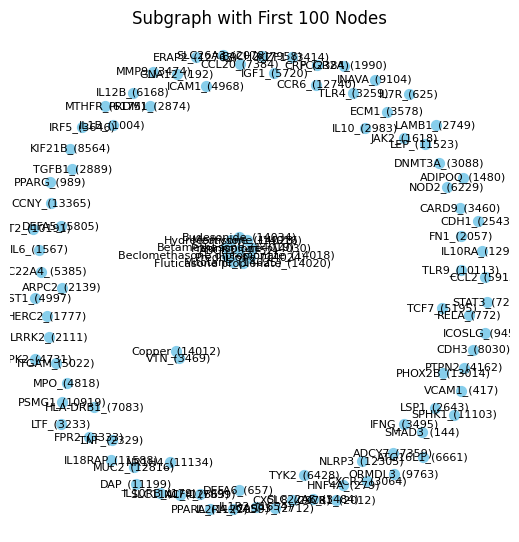

In [6]:
first_100_nodes = list(G.nodes)[:100]

subgraph = G.subgraph(first_100_nodes)

plt.figure(figsize=(5, 5))
nx.draw(subgraph, with_labels=True, node_size=50, font_size=8, node_color='skyblue')
plt.title("Subgraph with First 100 Nodes")
plt.show()


----------

### Bert model - transforming from text to tensor

In [7]:
from transformers import BertTokenizer, BertModel
from transformers import AutoTokenizer, AutoModel
import torch

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()  # Shape: (1, hidden_size)

# Example: Get embedding for a species description
text_description = """
    IL1B belongs to gene/protein category. The protein encoded by this gene is a member of the interleukin 1 cytokine family. This cytokine is produced by activated macrophages as a proprotein, which is proteolytically processed to its active form by caspase 1 (CASP1/ICE). This cytokine is an important mediator of the inflammatory response, and is involved in a variety of cellular activities, including cell proliferation, differentiation, and apoptosis. The induction of cyclooxygenase-2 (PTGS2/COX2) by this cytokine in the central nervous system (CNS) is found to contribute to inflammatory pain hypersensitivity. Similarly, IL-1B has been implicated in human osteoarthritis pathogenesis. Patients with severe Coronavirus Disease 2019 (COVID-19) present elevated levels of pro-inflammatory cytokines such as IL-1B in bronchial alveolar lavage fluid samples. The lung damage induced by the Severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) is to a large extent, a result of the inflammatory response promoted by cytokines such as IL-1B. This gene and eight other interleukin 1 family genes form a cytokine gene cluster on chromosome 2"""
text_embedding = get_text_embedding(text_description)


### Transform species into vectors

In [9]:
species_descriptions = pd.read_csv('species_backgrounds_final.csv')
res = []
for idx, row in species_descriptions.iterrows():
    res += [get_text_embedding(row['background'])]
species_descriptions['BERT_embedding'] = res

In [10]:
species_descriptions

,id,name,original_name,compartment,background,BERT_embedding
0,mwf626e95e_543f_41e4_aad4_c6bf60ab345b,IL6{serum},IL6,serum,Interleukin 6 (IL-6) is a cytokine with signif...,"[[-0.36046556, 0.1984801, 0.34831223, -0.13759..."
1,mwbbbce920_e8dd_4320_9386_fc94bfb2fc99,sgp130{serum},sgp130,serum,The provided documents do not offer explicit i...,"[[-0.33606362, 0.14078653, 0.28409472, -0.1816..."
2,mw810ff751_fa4e_4143_bd50_169b3e325e1e,sR_IL6_sgp130{serum},sR_IL6_sgp130,serum,Based on the provided context and general know...,"[[-0.35146952, 0.10439779, 0.35805824, -0.1242..."
3,mw114aa90f_5f5b_4fe8_9406_361c8489b6a1,CRP{serum},CRP,serum,C-reactive protein (CRP) is an acute-phase pro...,"[[-0.51451033, 0.34030703, 0.27825356, -0.1979..."
4,mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc,sR{serum},sR,serum,The context provided from the document does no...,"[[-0.19817938, 0.3326699, 0.28404108, -0.11455..."
5,mw03db56ac_8dc6_4931_ae82_fef706d2ee3d,sR_IL6{serum},sR_IL6,serum,"Based on the provided context, there is no spe...","[[-0.38143575, 0.16730621, 0.33593783, -0.1761..."
6,mwf345ed7a_0622_403c_b816_c8749a2c9ded,Ab{serum},Ab,serum,Based on the provided context and familiar pri...,"[[-0.26659864, 0.37297052, 0.12752607, -0.0740..."
7,mw1da111f2_a036_4392_8512_015005bdcbb7,Ab_sR{serum},Ab_sR,serum,The document context provided does not explici...,"[[-0.25748405, 0.3326551, 0.22365786, -0.12952..."
8,mw9947742a_0e4b_4636_9a4b_b6eef2a8f6ac,Ab_sR_IL6{serum},Ab_sR_IL6,serum,The specific species 'Ab_sR_IL6{serum}' does n...,"[[-0.37747848, 0.26106745, 0.29221672, -0.1456..."
9,CRP_Suppression___,CRP Suppression (%){serum},CRP Suppression (%),serum,"Based on the provided context, there is limite...","[[-0.4193665, 0.19158283, 0.2804547, -0.165872..."


### Graph behaviour

We pass each enriched node text through the BERT model to obtain an embedding

In [11]:
import gc

nodes_list = list(G.nodes)
total_len = len(nodes_list)
batch_size = 100 # for garbage collection

for node_idx in range(total_len):
    node = nodes_list[node_idx]
    
    try:
        if 'enriched_node' in G.nodes[node]:
            text = G.nodes[node]['enriched_node']
            G.nodes[node]['BERT_embedding'] = get_text_embedding(text)
        else:
            print(f"Warning: 'enriched_node' not found for node {node}")
    except Exception as e:
        print(f"Error processing node {node}: {e}")
    
    if node_idx % batch_size == 0 and node_idx != 0:
        print(f"{node_idx} / {total_len}")
        gc.collect()  # Force garbage collection to free memory


100 / 3426
200 / 3426
300 / 3426
400 / 3426
500 / 3426
600 / 3426
700 / 3426
800 / 3426
900 / 3426
1000 / 3426
1100 / 3426
1200 / 3426
1300 / 3426
1400 / 3426
1500 / 3426
1600 / 3426
1700 / 3426
1800 / 3426
1900 / 3426
2000 / 3426
2100 / 3426
2200 / 3426
2300 / 3426
2400 / 3426
2500 / 3426
2600 / 3426
2700 / 3426
2800 / 3426
2900 / 3426
3000 / 3426
3100 / 3426
3200 / 3426
3300 / 3426
3400 / 3426


### We add neighbor embeddings

In [12]:
proportions = [0.5, 0.1]  # example proportions for hops 1 and 2
neighbor_weight = 0.1

total_len = len(nodes_list)

# Loop through all nodes
for node_idx in range(total_len):
    
    node_name = nodes_list[node_idx]
    node = G.nodes[node_name]
    embedding = node['BERT_embedding']

    
    weight = 0
    neighbor_embedding = np.array([np.zeros(len(embedding[0]))])
    
    seen_nodes = set([node_name])
    
    for prop_idx in range(len(proportions)):
        # Find neighbors N hops away
        nodes_n_hops_away = [
            neighbor for neighbor, dist in nx.single_source_shortest_path_length(G, node_name).items() 
            if dist == prop_idx + 1 and neighbor not in seen_nodes
        ]
        
        # Update the seen nodes with the current level's neighbors
        seen_nodes.update(nodes_n_hops_away)
        
        # Add the embeddings for these neighbors, weighted by proportion
        for neighbor_idx in nodes_n_hops_away:
            neighbor_node = G.nodes[neighbor_idx]
            neighbor_embedding += neighbor_node['BERT_embedding'] * proportions[prop_idx]
            weight += proportions[prop_idx]  # Add the weight of the current hop level

    # Normalize the final embedding by the total weight
    neighbor_embedding = neighbor_embedding / weight
    node['FINAL_embedding'] = (embedding + neighbor_embedding * neighbor_weight) / (1 + neighbor_weight)
    #print(f"Final embedding for node {node_name}: {node['FINAL_embedding']}")


### Obtain most similar embedding

In [13]:
def compare_species_in_graph(text_embedding, G, nodes_list):
    best_node = None
    best_sim = -1
    
    for node_name in nodes_list:
        # we only consider gene/protein type nodes
        if (G.nodes[node_name]['type'] != 'gene/protein'):
            continue
        curr_emb = G.nodes[node_name]['FINAL_embedding']
    
        curr_emb = curr_emb.flatten()
        text_embedding = text_embedding.flatten()
        
        sim = np.dot(curr_emb, text_embedding) / (np.linalg.norm(curr_emb) * np.linalg.norm(text_embedding))
        #sim = np.linalg.norm(curr_emb - text_embedding)
        if ((best_node is None) | (sim > best_sim)):
            best_node = node_name
            best_sim = sim
    return best_node, best_sim

In [14]:
res = []
for idx, row in species_descriptions.iterrows():
    best_node, best_sim = compare_species_in_graph(row['BERT_embedding'], G, nodes_list)
    res += [best_node]

species_descriptions['best_node'] = res

-----------------

In [15]:
# Define primekg data by providing a local directory where the data is stored
primekg_data = PrimeKG(local_dir="../../data/primekg/")

# Invoke a method to load the data
primekg_data.load_data()

# Get primekg_nodes and primekg_edges
primekg_nodes = primekg_data.get_nodes()
primekg_edges = primekg_data.get_edges()

Loading nodes of PrimeKG dataset ...
../../data/primekg/primekg_nodes.tsv.gz already exists. Loading the data from the local directory.
Loading edges of PrimeKG dataset ...
../../data/primekg/primekg_edges.tsv.gz already exists. Loading the data from the local directory.


In [16]:
def fetch_code_in_graph(best_node, G):
    relevant_node_name = G.nodes[best_node]['name'].lower()
    query_str = f'node_name_lower.eq("{relevant_node_name}")'
    
    # Get the nodes related to IBD
    nodes_df = primekg_nodes.copy()
    nodes_df["node_name_lower"] = nodes_df.node_name.apply(lambda x: x.lower())
    nodes_df = nodes_df.query(query_str, engine='python')
    
    code = nodes_df.iloc[0]['node_id']
    
    return code

In [17]:
res = []
for idx, row in species_descriptions.iterrows():
    best_node = fetch_code_in_graph(row['best_node'], G)
    res += [best_node]

species_descriptions['best_code'] = res

In [18]:
species_descriptions

,id,name,original_name,compartment,background,BERT_embedding,best_node,best_code
0,mwf626e95e_543f_41e4_aad4_c6bf60ab345b,IL6{serum},IL6,serum,Interleukin 6 (IL-6) is a cytokine with signif...,"[[-0.36046556, 0.1984801, 0.34831223, -0.13759...",CXCL8_(2978),3576
1,mwbbbce920_e8dd_4320_9386_fc94bfb2fc99,sgp130{serum},sgp130,serum,The provided documents do not offer explicit i...,"[[-0.33606362, 0.14078653, 0.28409472, -0.1816...",IL2RA_(7059),3559
2,mw810ff751_fa4e_4143_bd50_169b3e325e1e,sR_IL6_sgp130{serum},sR_IL6_sgp130,serum,Based on the provided context and general know...,"[[-0.35146952, 0.10439779, 0.35805824, -0.1242...",IL1B_(1004),3553
3,mw114aa90f_5f5b_4fe8_9406_361c8489b6a1,CRP{serum},CRP,serum,C-reactive protein (CRP) is an acute-phase pro...,"[[-0.51451033, 0.34030703, 0.27825356, -0.1979...",CXCL8_(2978),3576
4,mw30ae63db_6cd3_4b6f_93ad_3350cd360bcc,sR{serum},sR,serum,The context provided from the document does no...,"[[-0.19817938, 0.3326699, 0.28404108, -0.11455...",CRP_(2384),1401
5,mw03db56ac_8dc6_4931_ae82_fef706d2ee3d,sR_IL6{serum},sR_IL6,serum,"Based on the provided context, there is no spe...","[[-0.38143575, 0.16730621, 0.33593783, -0.1761...",IL2RA_(7059),3559
6,mwf345ed7a_0622_403c_b816_c8749a2c9ded,Ab{serum},Ab,serum,Based on the provided context and familiar pri...,"[[-0.26659864, 0.37297052, 0.12752607, -0.0740...",CRP_(2384),1401
7,mw1da111f2_a036_4392_8512_015005bdcbb7,Ab_sR{serum},Ab_sR,serum,The document context provided does not explici...,"[[-0.25748405, 0.3326551, 0.22365786, -0.12952...",CRP_(2384),1401
8,mw9947742a_0e4b_4636_9a4b_b6eef2a8f6ac,Ab_sR_IL6{serum},Ab_sR_IL6,serum,The specific species 'Ab_sR_IL6{serum}' does n...,"[[-0.37747848, 0.26106745, 0.29221672, -0.1456...",IL2RA_(7059),3559
9,CRP_Suppression___,CRP Suppression (%){serum},CRP Suppression (%),serum,"Based on the provided context, there is limite...","[[-0.4193665, 0.19158283, 0.2804547, -0.165872...",IL2RA_(7059),3559
